In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyro-ppl
!pip install pot
!pip install tensorboard
!pip install torchdiffeq
!pip install openml

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [4]:
!rm -rf PFNExperiments
!git clone https://github.com/ArikReuter/PFNExperiments


Cloning into 'PFNExperiments'...
remote: Enumerating objects: 1326, done.
remote: Counting objects: 100% (99/99), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 1326 (delta 57), reused 64 (delta 29), pack-reused 1227
Receiving objects: 100% (1326/1326), 57.47 MiB | 10.45 MiB/s, done.
Resolving deltas: 100% (941/941), done.


In [5]:
import torch
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig

from PFNExperiments.LinearRegression.GenerativeModels.GenerateX import simulate_X_uniform
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code
from PFNExperiments.LinearRegression.GenerativeModels.Quantizer import Quantizer
from PFNExperiments.LinearRegression.Models.Transformer_CNF import TransformerCNFConditionalDecoder
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_training_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed, nll_loss_full_gaussian
from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian, ModelPosteriorFullGaussian2
from PFNExperiments.LinearRegression.Models.AugmentLoss import add_l2_loss_nll_loss
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF_LearnedBaseDist import ModelToPosteriorCNF_LearnedBaseDist

from PFNExperiments.Training.FlowMatching.CFMLossOT2 import CFMLossOT2

from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison
from PFNExperiments.LinearRegression.Models.ModelToPosteriorCNF import ModelToPosteriorCNF
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

from PFNExperiments.LinearRegression.GenerativeModels.Curriculum import Curriculum
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataCurriculumCFM import GenerateDataCurriculumCFM

from PFNExperiments.Training.TrainerCurriculumCNF import TrainerCurriculumCNF

from PFNExperiments.LinearRegression.ComparisonModels.AnalyticalSolutionsLM import PosteriorLM_IG
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_ig_batched, make_lm_program_ig
from PFNExperiments.LinearRegression.GenerativeModels.GenerateX import simulate_X_uniform

from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

from PFNExperiments.Training.FlowMatching.Couplings import MiniBatchOTCoupling

from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide

from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoIAFNormal, AutoStructured
from PFNExperiments.Evaluation.Evaluate import Evaluate

from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML

from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld

In [6]:
torch.backends.cudnn.benchmark = True

In [7]:
N = 50
P = 5
BATCH_SIZE = 1024
N_EPOCHS = 100
N_SAMPLES_PER_EPOCH = 500_000
N_BATCHES_PER_EPOCH = N_SAMPLES_PER_EPOCH//BATCH_SIZE
SAVE_PATH = "/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM"
SAVE_PATH_EVALUATION = f"{SAVE_PATH}/PFN_Experiments_CFM_InverseGamma_v2_discretizeX_RealWorldEvaluation"

#BATCH_SIZE = 128

In [8]:
a = 5.0
b = 2.0
tau = 1.0

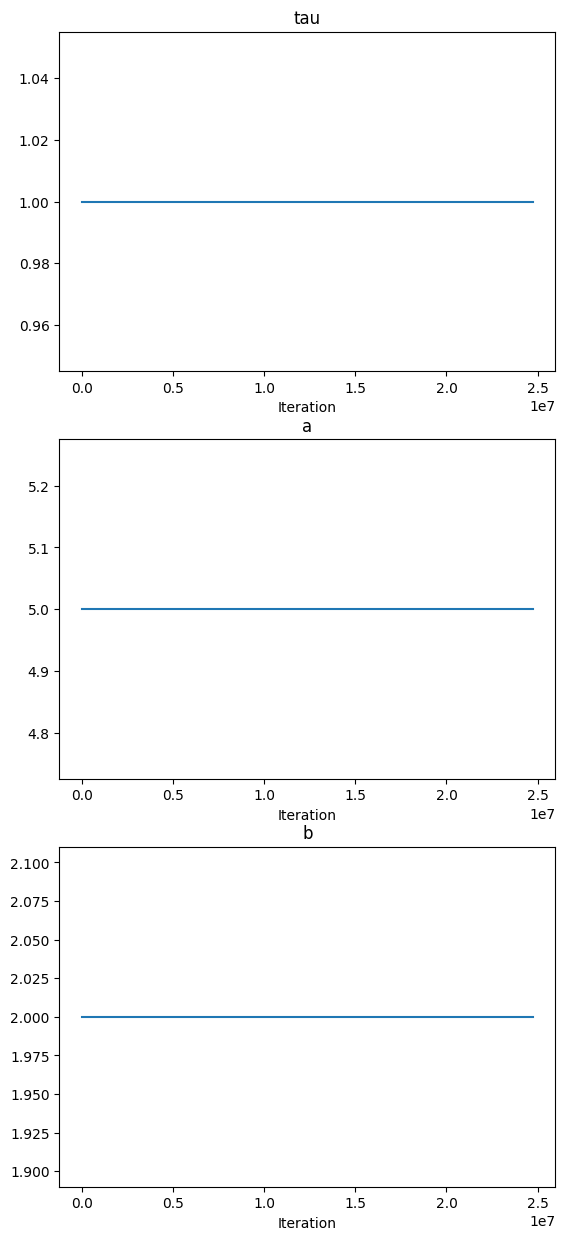

In [9]:
curriculum = Curriculum(max_iter=int(N_EPOCHS*N_BATCHES_PER_EPOCH*BATCH_SIZE*0.5))
curriculum.add_param_list(
    [
    ("tau", curriculum.constant_scheduler(tau)),
    ("a", curriculum.constant_scheduler(a)),
    ("b", curriculum.constant_scheduler(b)),

    ]
)
curriculum.plot_all_schedules()

In [10]:
curriculum.get_params(299*N_SAMPLES_PER_EPOCH)

{'tau': 1.0, 'a': 5.0, 'b': 2.0}

In [11]:
data_generator = GenerateDataCurriculumCFM(
    pprogram_maker= make_lm_program_ig_batched,
    curriculum= curriculum,
    #coupling = None
)

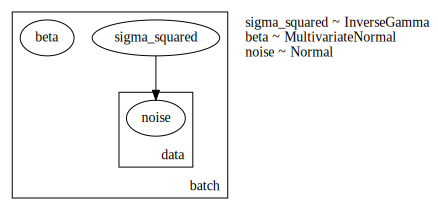

In [12]:
data_generator.render_model()

In [13]:
epoch_loader = data_generator.make_epoch_loader(
    n = N,
    p = P,
    number_of_batches_per_epoch = N_BATCHES_PER_EPOCH,
    n_epochs = N_EPOCHS,
    batch_size= BATCH_SIZE,
    train_frac= 0.5,
    val_frac= 0.1,
    shuffle=False,
    n_samples_to_generate_at_once = 250_000
)

The number of batches times the number of epochs must be equal to the total number of iterations in the curriculum. But got 49971200 and 24985600 respectively


In [14]:
#save_path_model = "/content/drive/MyDrive/PFN_Experiments/Training_Runs/experiment_2024_05_29_07_37_35/model.pth"

In [15]:

model = TransformerCNFConditionalDecoder(
    n_input_features_encoder = P+1,
    n_input_features_decoder = P,
    d_model_encoder = 512,
    d_model_decoder = 512,
    n_heads_encoder = 8,
    n_heads_decoder = 8,
    d_ff_encoder = 1024,
    d_ff_decoder = 1024,
    dropout_encoder = 0.1,
    dropout_decoder = 0.1,
    n_conditional_input_features =  1,
    n_condition_features = 512,
    n_layers_condition_embedding = 3,
    n_layers_encoder = 8,
    n_layers_decoder = 6,
    use_positional_encoding_encoder = True,
    use_positional_encoding_decoder = False,
    use_self_attention_decoder = False,
    output_dim = P,
    d_final_processing = 512,
    n_final_layers = 3,
    dropout_final = 0.1,
    treat_z_as_sequence = False,
)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [17]:
'{:.2e}'.format(count_parameters(model))

'4.31e+07'

In [18]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

In [19]:
lr = 1e-4
opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

In [20]:
loss_fun = CFMLossOT2(
    sigma_min=1e-2
)

In [21]:
scheduler = OneCycleLR(opt,
                       max_lr = 1e-4,
                       epochs = N_EPOCHS,
                       steps_per_epoch = N_SAMPLES_PER_EPOCH//BATCH_SIZE,
                       pct_start = 0.1,
                       div_factor=25.0,
                       final_div_factor=1e2)

#scheduler = ReduceLROnPlateau(opt)

additional_evals = {
}

In [22]:
#?TrainerCurriculumCNF

In [23]:
trainer = TrainerCurriculumCNF(
    model = model,
    optimizer=opt,
    scheduler = scheduler,
    loss_function=loss_fun,
    epoch_loader = epoch_loader,
    evaluation_functions= additional_evals,
    n_epochs = N_EPOCHS,
    early_stopping_patience = 200,
    schedule_step_on = "batch",
    save_path = SAVE_PATH,
    coupling = None,
    use_same_timestep_per_batch = False,
    use_train_mode_during_validation = False,
    max_gradient_norm = 1.0

)

In [24]:
trainer.set_new_save_path("/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM/experiment_2024_07_27_15_58_55")

trainer.save_path

'/content/drive/MyDrive/PFN_Experiments/Training_RunsCFM/experiment_2024_07_27_15_58_55'

In [25]:
try:
  trainer.load_best_model()
except:
  print("Could not load model")
  pass

In [26]:
model.eval()
trainer.load_best_model()
trainer.model.cuda()

TransformerCNFConditionalDecoder(
  (condition_embedding_layer): MLP(
    (linear1): Linear_block(
      (fc): Linear(in_features=1, out_features=512, bias=True)
      (act): LeakyReLU(negative_slope=0.01)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (hidden_layers): Sequential(
      (0): Linear_skip_block(
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Linear_skip_block(
        (fc): Linear(in_features=512, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (2): Linear_skip_block(
    

In [27]:
#trainer.test()

In [28]:
N_SAMPLES_PER_MODEL = 1_000

In [41]:
full_model = ModelToPosteriorCNF(
    model = model.eval(),
    sample_name = "beta",
    sample_shape = (P,),
    n_samples=N_SAMPLES_PER_MODEL,
    batch_size = BATCH_SIZE,
    solve_adjoint = True,
    atol = 1e-6,
    rtol = 1e-6,
    #device = torch.device("cpu")
)
benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)



benchmark_params_ppgrogram = data_generator.curriculum.get_params(-1)
print(f"params for pprogram: {benchmark_params_ppgrogram}")

pprogram1 = make_lm_program_ig(**benchmark_params_ppgrogram)

pprogram1_y = return_only_y(pprogram1)
print_code(pprogram1)






params for pprogram: {'tau': 1.0, 'a': 5.0, 'b': 2.0}
        def multivariate_lm_return_dict(x: torch.Tensor, y: torch.Tensor = None) -> dict:
                # Define distributions for the global parameters
                sigma_squared_dist = dist.InverseGamma(a, b)

                beta_cov = torch.eye(x.shape[1]) * (tau ** 2)  # the covariance matrix of the parameters of the linear model

                sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist).squeeze()

                beta_dist = dist.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)
                beta = pyro.sample("beta", beta_dist)

                # Compute mean using matrix multiplication
                mean = torch.matmul(x, beta)

                with pyro.plate("data", len(x)):
                        y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)


                return {
                        "x": x,
                        "y": y,
                      

In [42]:
N_SAMPLES_PER_MODEL = 1000

In [43]:
analytical_solution = PosteriorLM_IG(
    pprogram_dict= {
        "tau": tau,
        "a": a,
        "b": b
    },
    n_samples=N_SAMPLES_PER_MODEL
)


hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

vi_diag = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoDiagonalNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)
vi_laplace = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoLaplaceApproximation,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_autoIAF = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun=AutoIAFNormal,
    #additional_make_guide_args={"num_transforms": 5, "hidden_dim" : 100},
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-3
)

vi_autostrucured = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun=AutoStructured,
    n_steps = 2000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)


In [44]:

getdata = GetDataOpenML(
    preprocessor = Preprocessor(
        N_datapoints = N,
        P_features = P,
        target_mean = 0.0,
        target_var = 2.0
    ),
    save_path = "/content/drive/MyDrive/PFN_Experiments/DatasetsOpenML/numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

An error occured while preprocessing the dataset with id 361086. Skipping the dataset


In [45]:
len(datasets)

18

In [47]:
eval_rw = EvaluateRealWorld(
    posterior_model = analytical_solution,
    evaluation_datasets = datasets,
    comparison_models = [
                        #hmc_sampler,
                        full_model,
                        vi_multivariate_normal,
                        vi_diag,
                        #vi_laplace,
                        #vi_autoIAF,
                        #vi_autostrucured,
                        ],
    n_evaluation_cases = 3,
    save_path = SAVE_PATH_EVALUATION,
    overwrite_results = True
)

The save path is not empty and the overwrite flag is set, the results will be overwritten


In [48]:
eval_rw.run_evaluation()

Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]
0it [00:00, ?it/s]
Sampling posterior:   6%|▌         | 1/18 [01:24<24:03, 84.89s/it]
0it [00:00, ?it/s]
Sampling posterior:  11%|█         | 2/18 [03:03<24:47, 92.98s/it]
0it [00:00, ?it/s]
Sampling posterior:  17%|█▋        | 3/18 [04:28<22:17, 89.18s/it]
0it [00:00, ?it/s]
Sampling posterior:  22%|██▏       | 4/18 [06:02<21:16, 91.17s/it]
0it [00:00, ?it/s]
Sampling posterior:  28%|██▊       | 5/18 [07:31<19:37, 90.59s/it]
0it [00:00, ?it/s]
Sampling posterior:  33%|███▎      | 6/18 [09:03<18:12, 91.03s/it]
0it [00:00, ?it/s]
Sampling posterior:  39%|███▉      | 7/18 [10:38<16:52, 92.07s/it]
0it [00:00, ?it/s]
Sampling posterior:  44%|████▍     | 8/18 [12:02<14:57, 89.71s/it]
0it [00:00, ?it/s]
Sampling posterior:  50%|█████     | 9/18 [13:43<13:59, 93.26s/it]
0it [00:00, ?it/s]
Sampling posterior:  56%|█████▌    | 10/18 [15:22<12:39, 94.95s/it]
0it [00:00, ?it/s]
Sampling posterior:  61%|██████    | 11/18 [16:47<10:43, 91.9

....................


Sampling posterior:   6%|▌         | 1/18 [00:13<03:45, 13.24s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:26<03:29, 13.12s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:39<03:16, 13.08s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [00:52<03:04, 13.15s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [01:05<02:50, 13.12s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:18<02:37, 13.11s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [01:31<02:24, 13.14s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [01:45<02:11, 13.19s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [01:58<01:58, 13.18s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [02:11<01:45, 13.14s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [02:24<01:32, 13.19s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [02:37<01:18, 13.12s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [02:50<01:05, 13.10s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [03:03<00:52, 13.09s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [03:16<00:39, 13.12s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [03:29<00:26, 13.08s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [03:43<00:13, 13.22s/it]

....................


Sampling posterior:   0%|          | 0/18 [00:00<?, ?it/s]

....................


Sampling posterior:   6%|▌         | 1/18 [00:11<03:11, 11.28s/it]

....................


Sampling posterior:  11%|█         | 2/18 [00:22<02:59, 11.20s/it]

....................


Sampling posterior:  17%|█▋        | 3/18 [00:33<02:48, 11.25s/it]

....................


Sampling posterior:  22%|██▏       | 4/18 [00:45<02:39, 11.37s/it]

....................


Sampling posterior:  28%|██▊       | 5/18 [00:56<02:28, 11.41s/it]

....................


Sampling posterior:  33%|███▎      | 6/18 [01:08<02:16, 11.39s/it]

....................


Sampling posterior:  39%|███▉      | 7/18 [01:19<02:05, 11.42s/it]

....................


Sampling posterior:  44%|████▍     | 8/18 [01:30<01:53, 11.37s/it]

....................


Sampling posterior:  50%|█████     | 9/18 [01:42<01:41, 11.32s/it]

....................


Sampling posterior:  56%|█████▌    | 10/18 [01:53<01:30, 11.33s/it]

....................


Sampling posterior:  61%|██████    | 11/18 [02:05<01:19, 11.41s/it]

....................


Sampling posterior:  67%|██████▋   | 12/18 [02:16<01:08, 11.42s/it]

....................


Sampling posterior:  72%|███████▏  | 13/18 [02:27<00:56, 11.37s/it]

....................


Sampling posterior:  78%|███████▊  | 14/18 [02:39<00:45, 11.35s/it]

....................


Sampling posterior:  83%|████████▎ | 15/18 [02:50<00:34, 11.45s/it]

....................


Sampling posterior:  89%|████████▉ | 16/18 [03:01<00:22, 11.35s/it]

....................


Sampling posterior:  94%|█████████▍| 17/18 [03:13<00:11, 11.32s/it]

....................


Sampling posterior: 100%|██████████| 18/18 [03:24<00:00, 11.36s/it]


Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


Model 1  \
0  <PFNExperiments.LinearRegression.ComparisonMod...   
1  <PFNExperiments.LinearRegression.ComparisonMod...   
2  <PFNExperiments.LinearRegression.ComparisonMod...   
3  <PFNExperiments.LinearRegression.Models.ModelT...   
4  <PFNExperiments.LinearRegression.Models.ModelT...   
5  Variational Inference with guide: AutoMultivar...   

                                             Model 2  \
0  <PFNExperiments.LinearRegression.Models.ModelT...   
1  Variational Inference with guide: AutoMultivar...   
2  Variational Inference with guide: AutoDiagonal...   
3  Variational Inference with guide: AutoMultivar...   
4  Variational Inference with guide: AutoDiagonal...   
5  Variational Inference with guide: AutoDiagonal...   

   Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
0                                         1.669254  0.561240   
1                                         1.035262  0.243262   
2                                         1.190087  0.484998   
3                                         1.572036  0.645194   
4                                         1.655721  0.904667   
5                                         0.833938  0.190455   

   Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean   Std_MMD  \
0          0.851639                                        0.413330  0.327198   
1          0.626389                                        0.350538  0.592853   
2          0.736278                                        0.301208  0.942623   
3          0.847500                                        0.492345  0.555158   
4          0.879000                                        0.457744  0.853258   
5          0.653500                                        0.142079  0.327321   

   Std_cst_roc_auc  
0         0.054792  
1         0.092035  
2         0.118127  
3         0.073887  
4         0.074399  
5         0.139098

P-values:


Pair 1: Model A  \
0   <PFNExperiments.LinearRegression.ComparisonMod...   
1   <PFNExperiments.LinearRegression.ComparisonMod...   
2   <PFNExperiments.LinearRegression.ComparisonMod...   
3   <PFNExperiments.LinearRegression.ComparisonMod...   
4   <PFNExperiments.LinearRegression.ComparisonMod...   
5   <PFNExperiments.LinearRegression.ComparisonMod...   
6   <PFNExperiments.LinearRegression.ComparisonMod...   
7   <PFNExperiments.LinearRegression.ComparisonMod...   
8   <PFNExperiments.LinearRegression.ComparisonMod...   
9   <PFNExperiments.LinearRegression.Models.ModelT...   
10  <PFNExperiments.LinearRegression.Models.ModelT...   
11  <PFNExperiments.LinearRegression.Models.ModelT...   

                                      Pair 1: Model B  \
0   <PFNExperiments.LinearRegression.Models.ModelT...   
1   <PFNExperiments.LinearRegression.Models.ModelT...   
2   <PFNExperiments.LinearRegression.Models.ModelT...   
3   <PFNExperiments.LinearRegression.Models.ModelT...   
4   Variational Inference with guide: AutoMultivar...   
5   Variational Inference with guide: AutoMultivar...   
6   Variational Inference with guide: AutoMultivar...   
7   Variational Inference with guide: AutoDiagonal...   
8   Variational Inference with guide: AutoDiagonal...   
9   Variational Inference with guide: AutoMultivar...   
10  Variational Inference with guide: AutoMultivar...   
11  Variational Inference with guide: AutoDiagonal...   

                                      Pair 2: Model A  \
0   <PFNExperiments.LinearRegression.ComparisonMod...   
1   <PFNExperiments.LinearRegression.ComparisonMod...   
2   <PFNExperiments.LinearRegression.Models.ModelT...   
3   <PFNExperiments.LinearRegression.Models.ModelT...   
4   <PFNExperiments.LinearRegression.ComparisonMod...   
5   <PFNExperiments.LinearRegression.Models.ModelT...   
6   Variational Inference with guide: AutoMultivar...   
7   <PFNExperiments.LinearRegression.Models.ModelT...   
8   Variational Inference with guide: AutoMultivar...   
9   <PFNExperiments.LinearRegression.Models.ModelT...   
10  Variational Inference with guide: AutoMultivar...   
11  Variational Inference with guide: AutoMultivar...   

                                      Pair 2: Model B  \
0   Variational Inference with guide: AutoMultivar...   
1   Variational Inference with guide: AutoDiagonal...   
2   Variational Inference with guide: AutoMultivar...   
3   Variational Inference with guide: AutoDiagonal...   
4   Variational Inference with guide: AutoDiagonal...   
5   Variational Inference with guide: AutoMultivar...   
6   Variational Inference with guide: AutoDiagonal...   
7   Variational Inference with guide: AutoDiagonal...   
8   Variational Inference with guide: AutoDiagonal...   
9   Variational Inference with guide: AutoDiagonal...   
10  Variational Inference with guide: AutoDiagonal...   
11  Variational Inference with guide: AutoDiagonal...   

    Wasserstein_distance with metric euclidean_p-value  MMD_p-value  \
0                                        2.402673e-05      0.000024   
1                                        4.721732e-04      0.003792   
2                                        4.197908e-01      0.936956   
3                                        9.118264e-01      0.438254   
4                                        7.384365e-02      0.020049   
5                                        5.974088e-04      0.000082   
6                                        1.550545e-02      0.141238   
7                                        1.474381e-03      0.002515   
8                                        8.181999e-05      0.003094   
9                                        5.583365e-01      0.334556   
10                                       2.245523e-06      0.000228   
11                                       7.366600e-07      0.000055   

    cst_roc_auc_p-value  
0              0.000005  
1              0.002037  
2              0.837043  
3              0.311299  
4              0

{'summarized_results': {'model_comparison_among_each_other':                                              Model 1  \
  0  <PFNExperiments.LinearRegression.ComparisonMod...   
  1  <PFNExperiments.LinearRegression.ComparisonMod...   
  2  <PFNExperiments.LinearRegression.ComparisonMod...   
  3  <PFNExperiments.LinearRegression.Models.ModelT...   
  4  <PFNExperiments.LinearRegression.Models.ModelT...   
  5  Variational Inference with guide: AutoMultivar...   
  
                                               Model 2  \
  0  <PFNExperiments.LinearRegression.Models.ModelT...   
  1  Variational Inference with guide: AutoMultivar...   
  2  Variational Inference with guide: AutoDiagonal...   
  3  Variational Inference with guide: AutoMultivar...   
  4  Variational Inference with guide: AutoDiagonal...   
  5  Variational Inference with guide: AutoDiagonal...   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                         1.669254  0.5

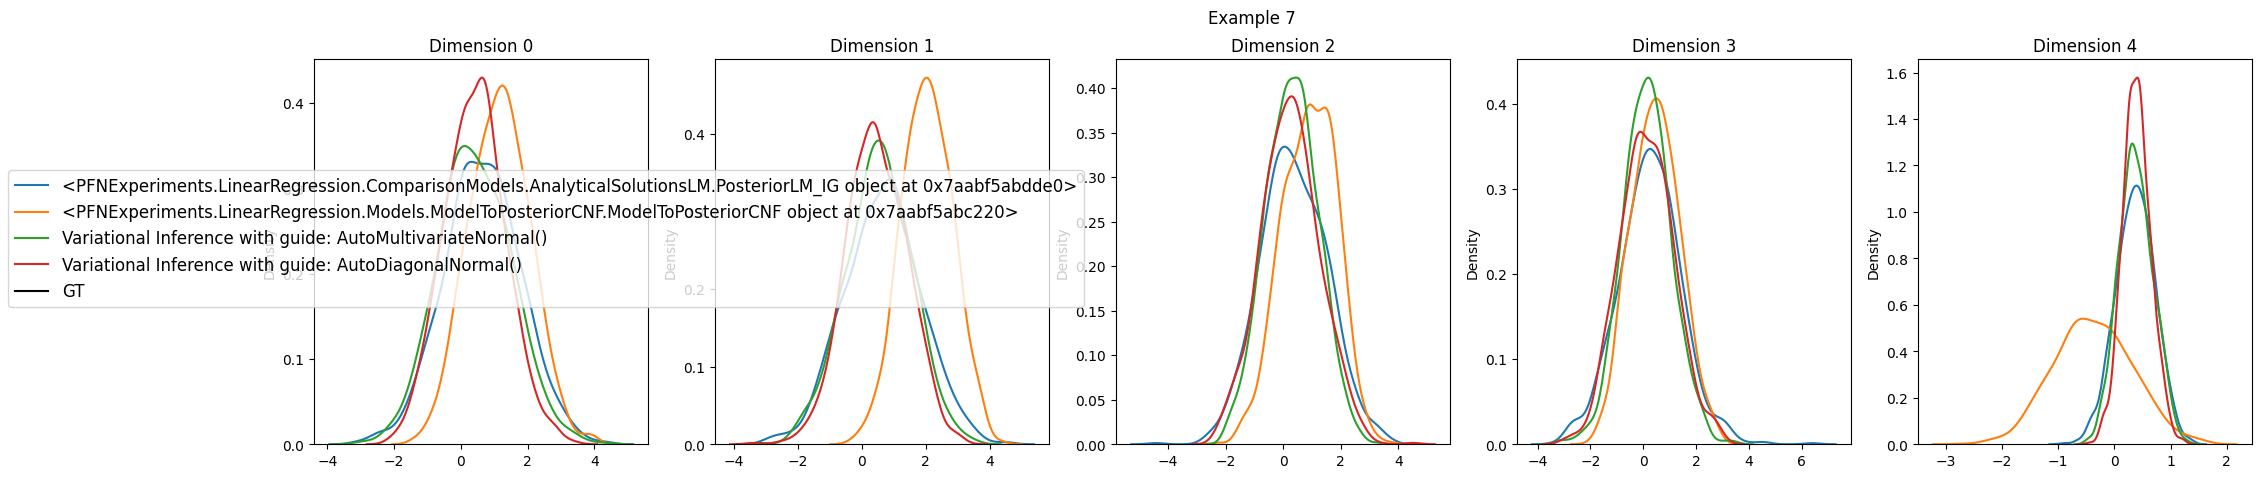

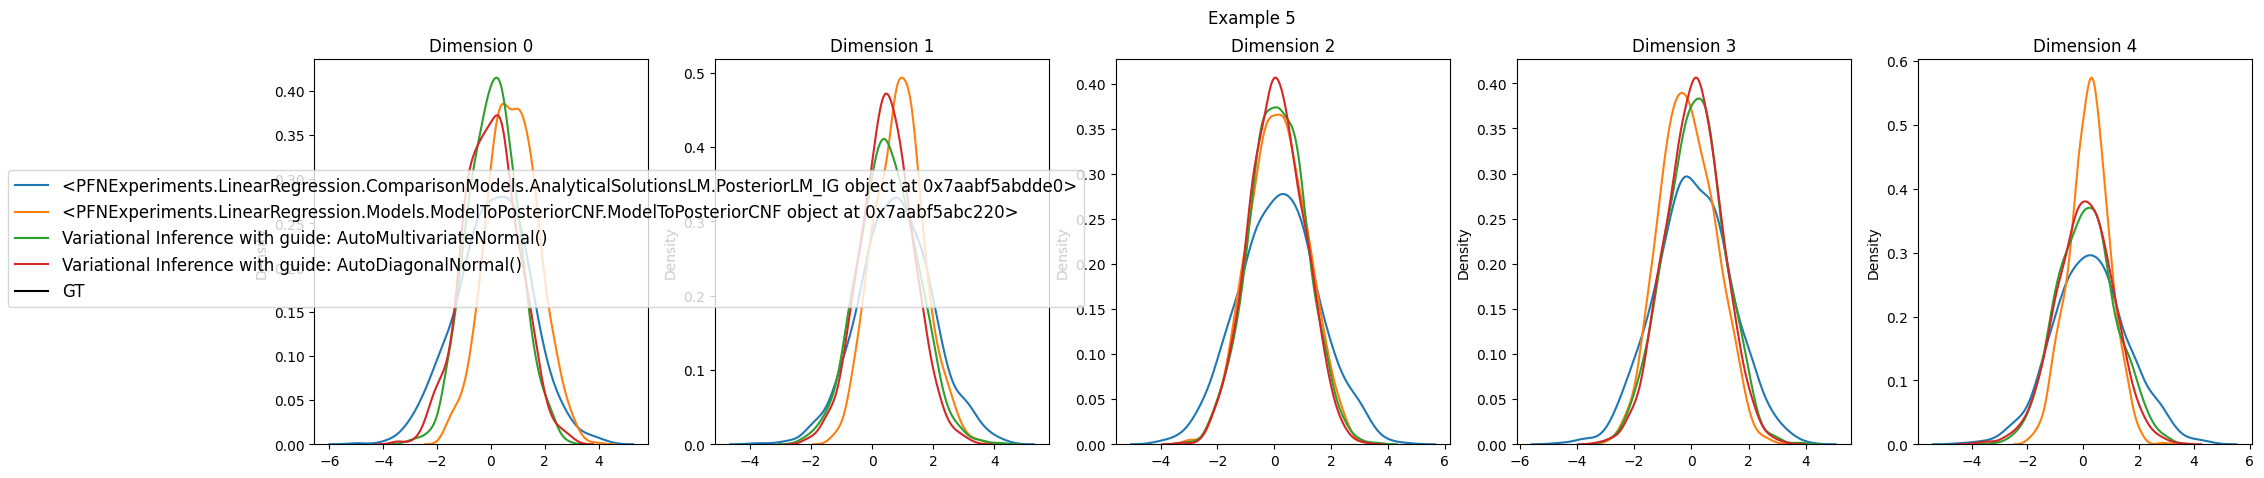

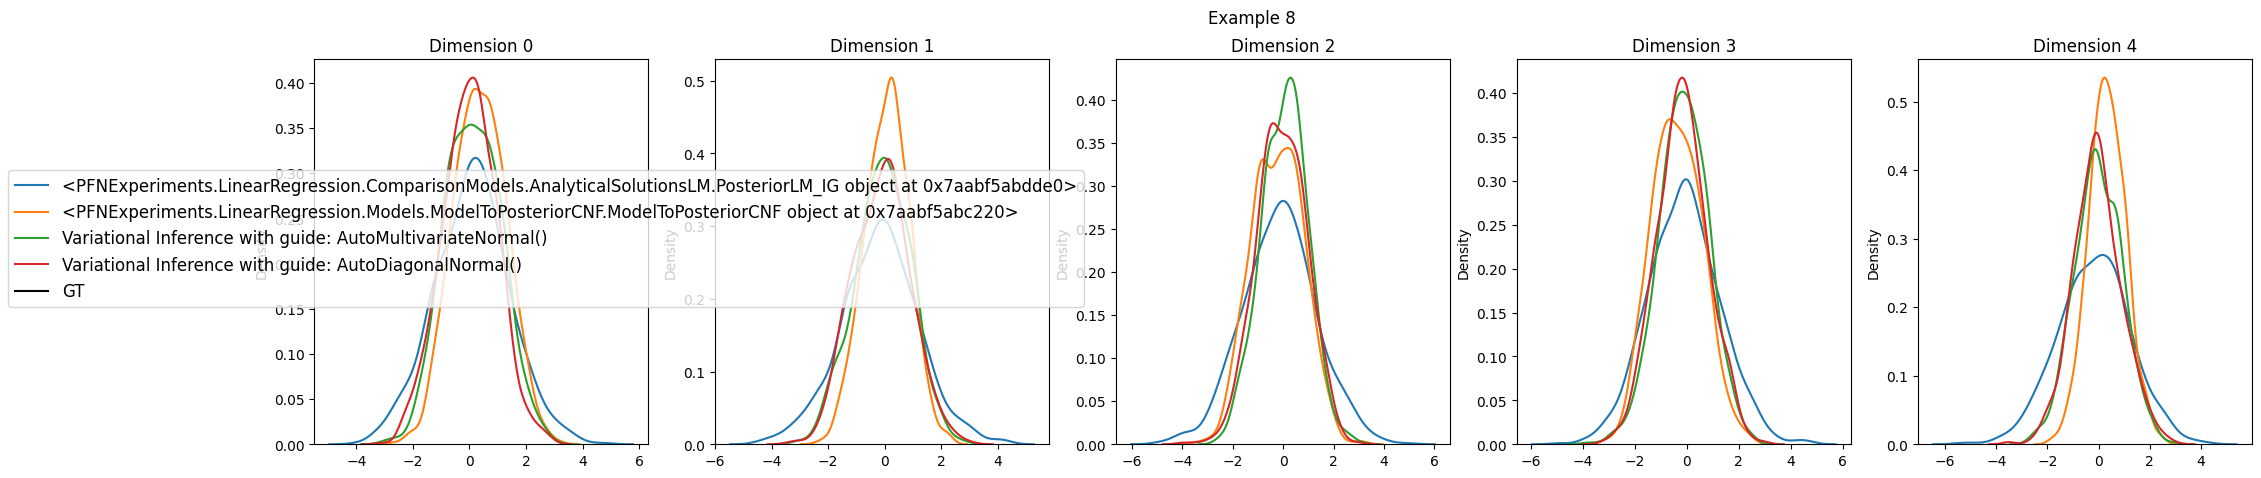

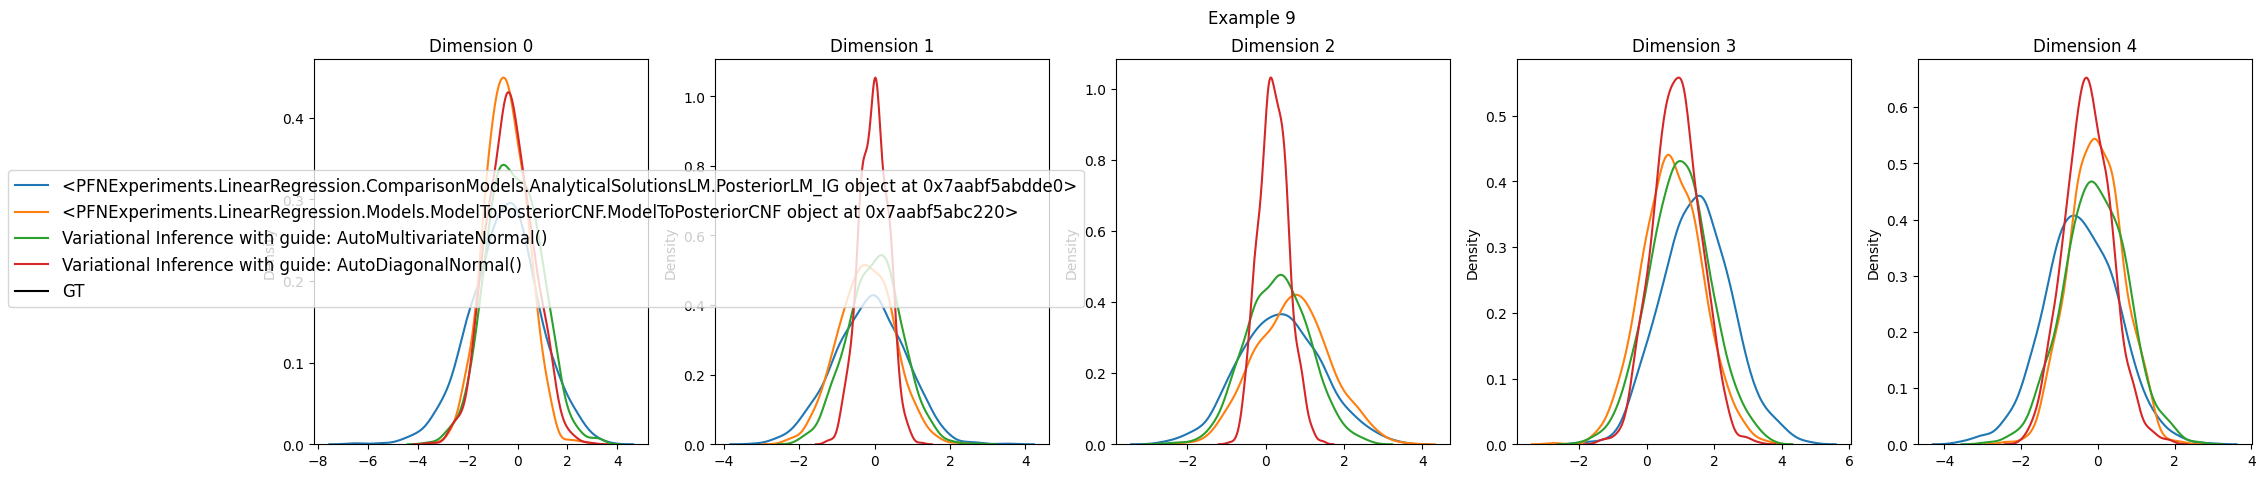

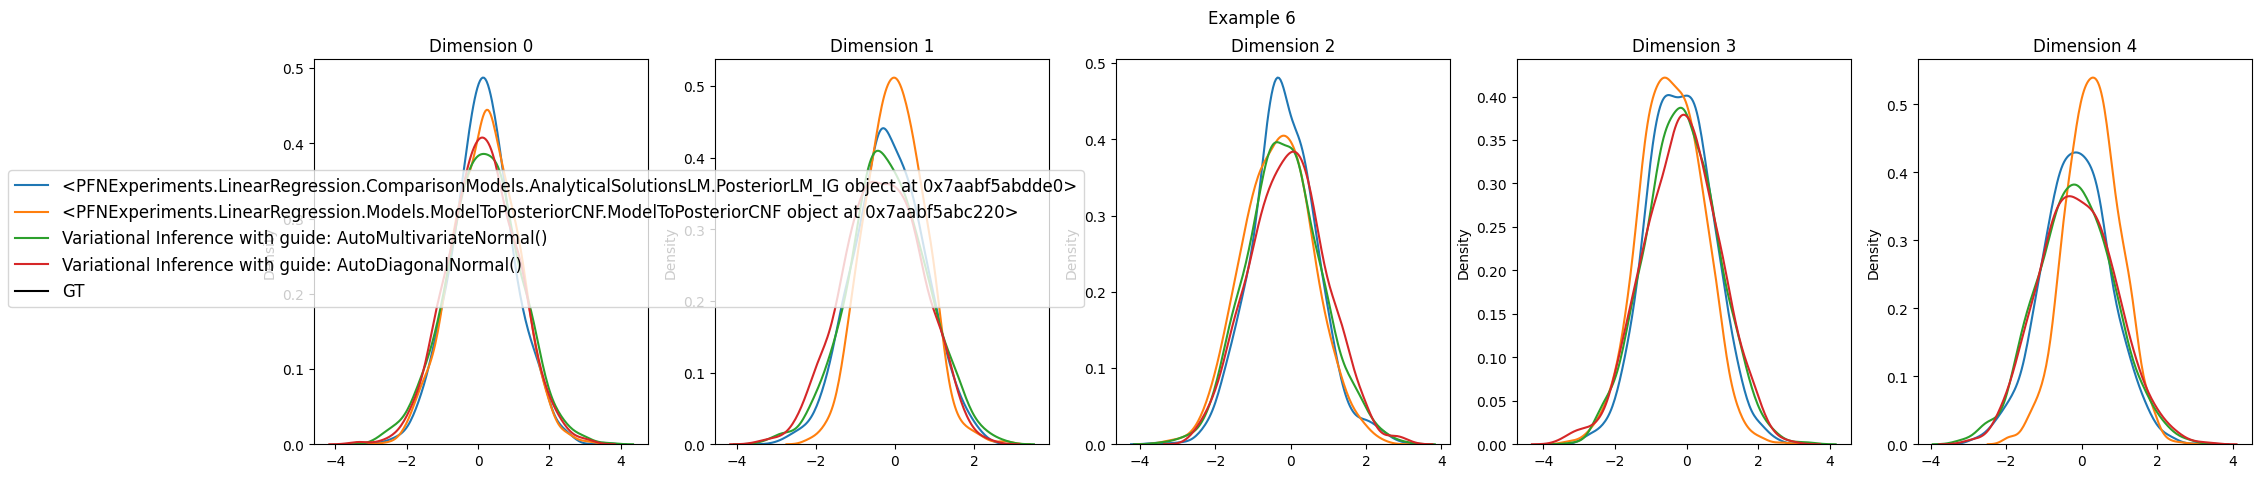

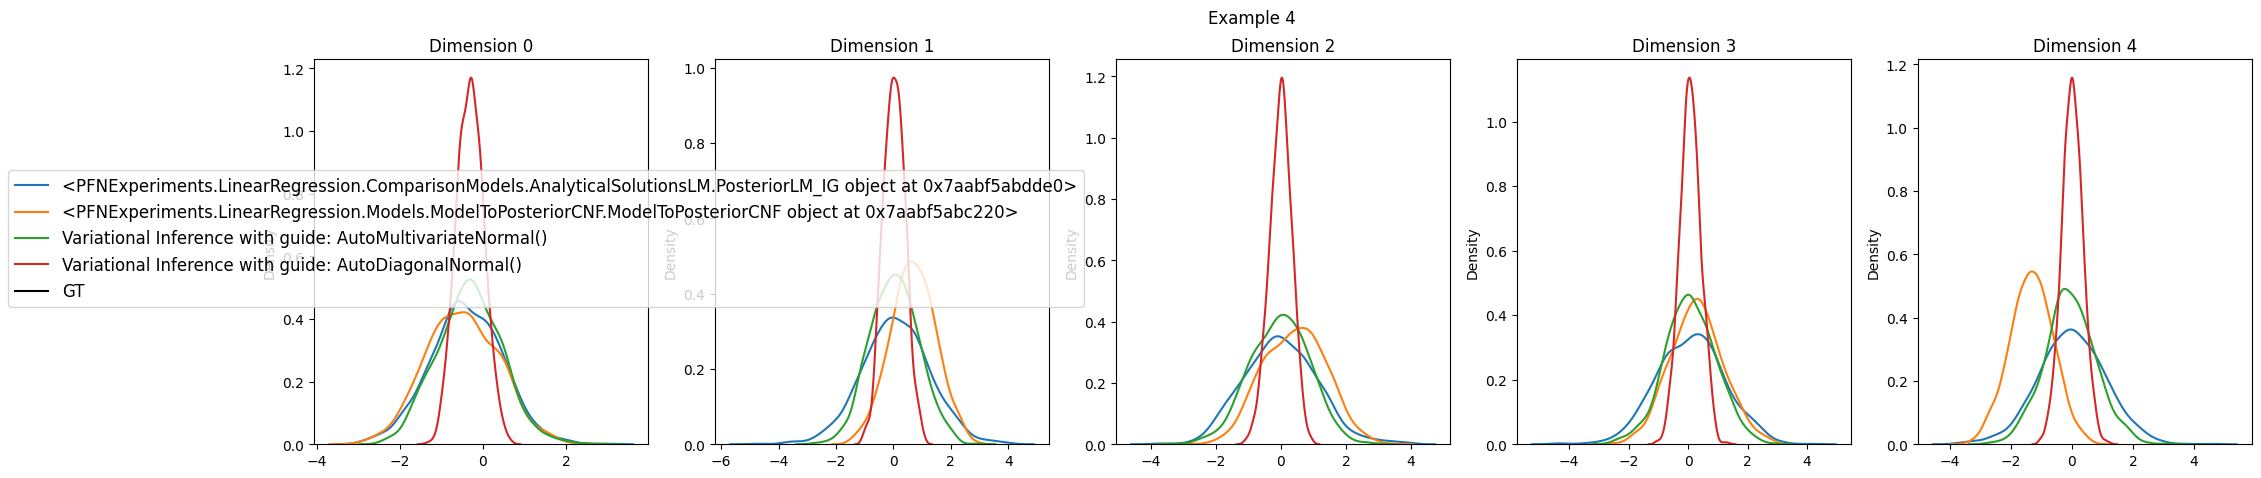

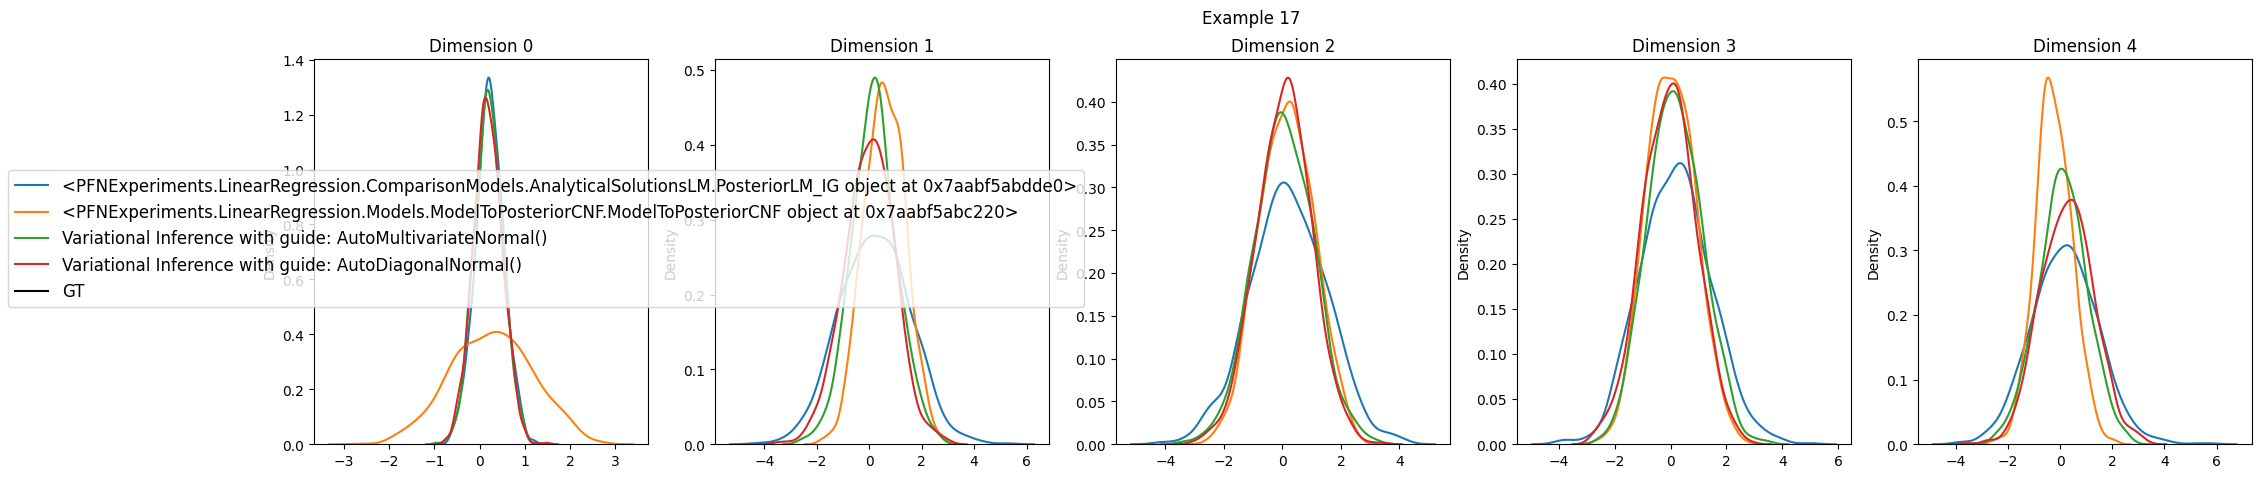

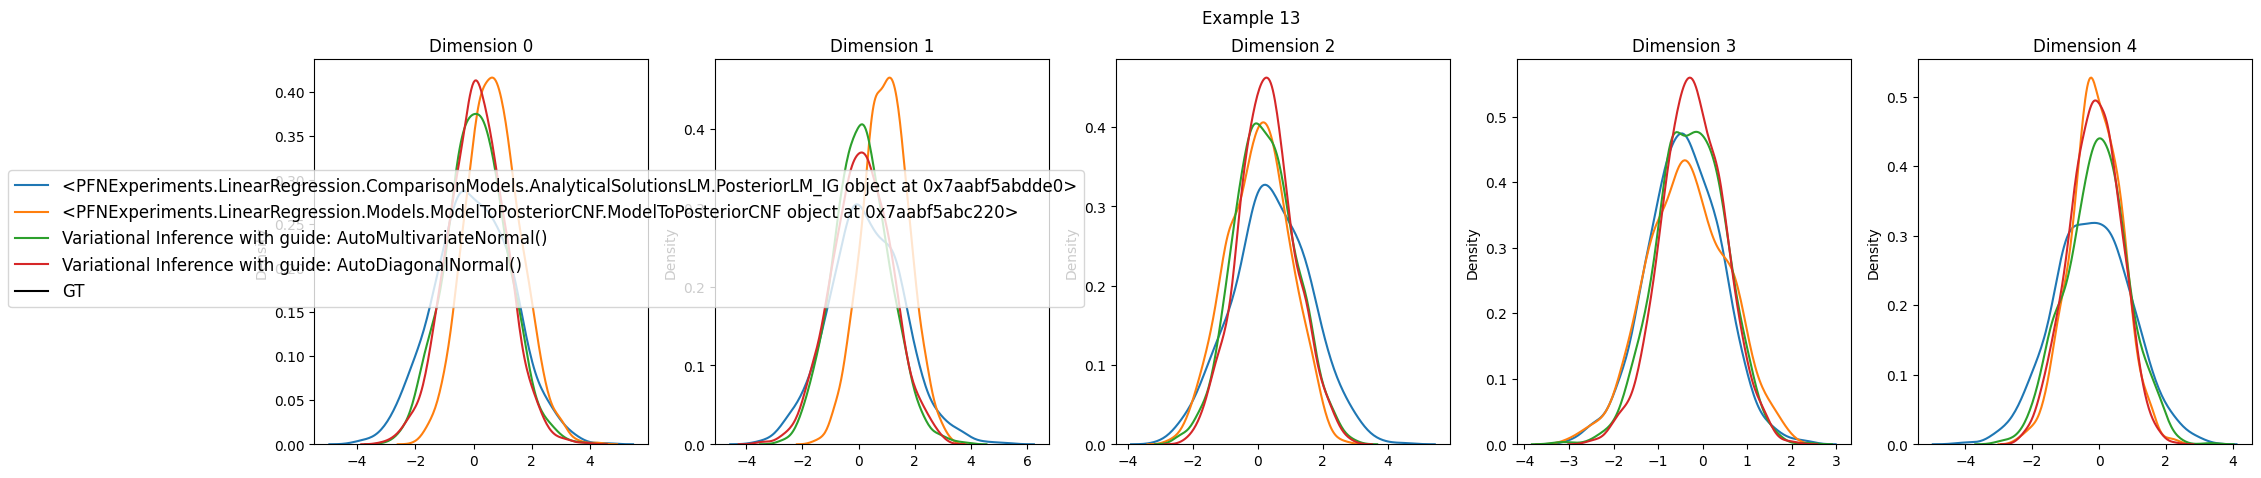

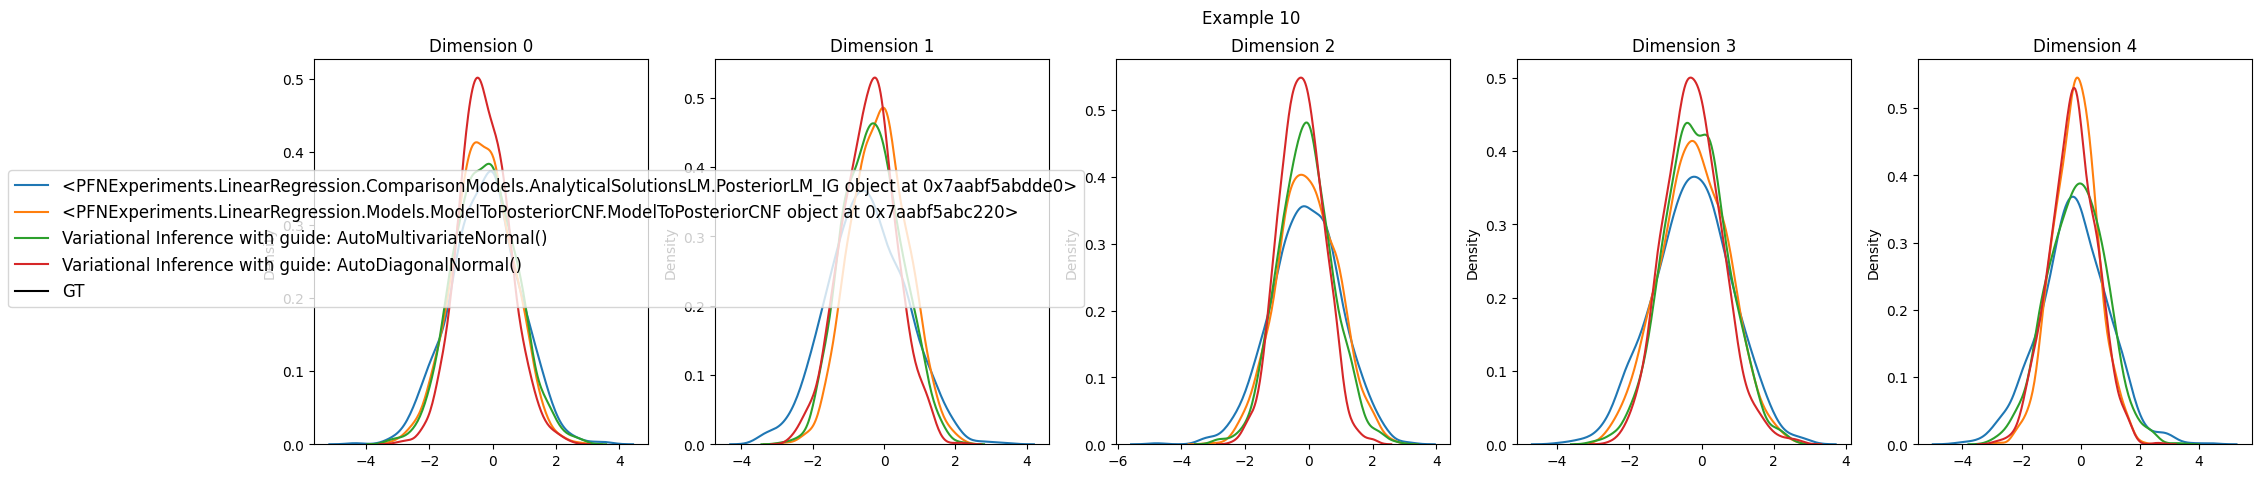

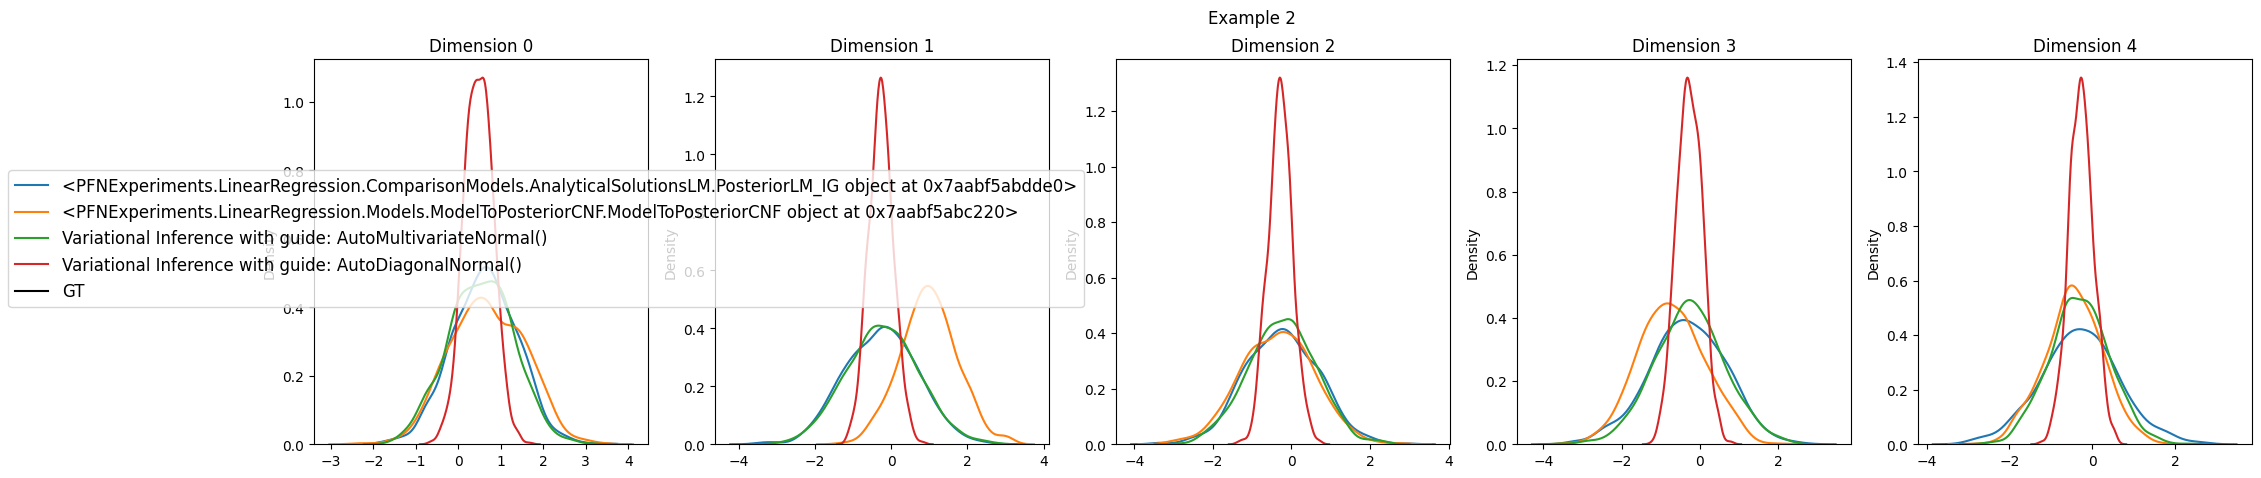

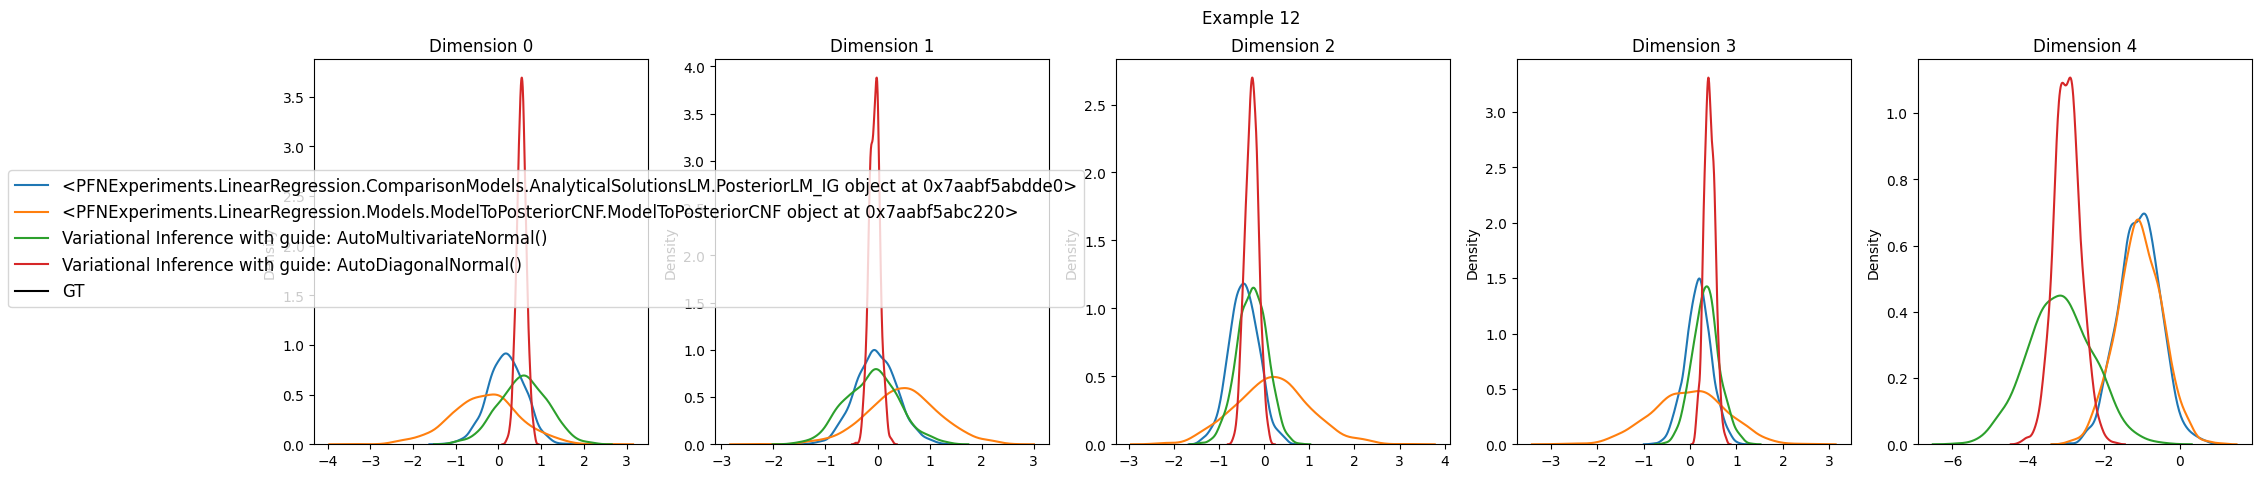

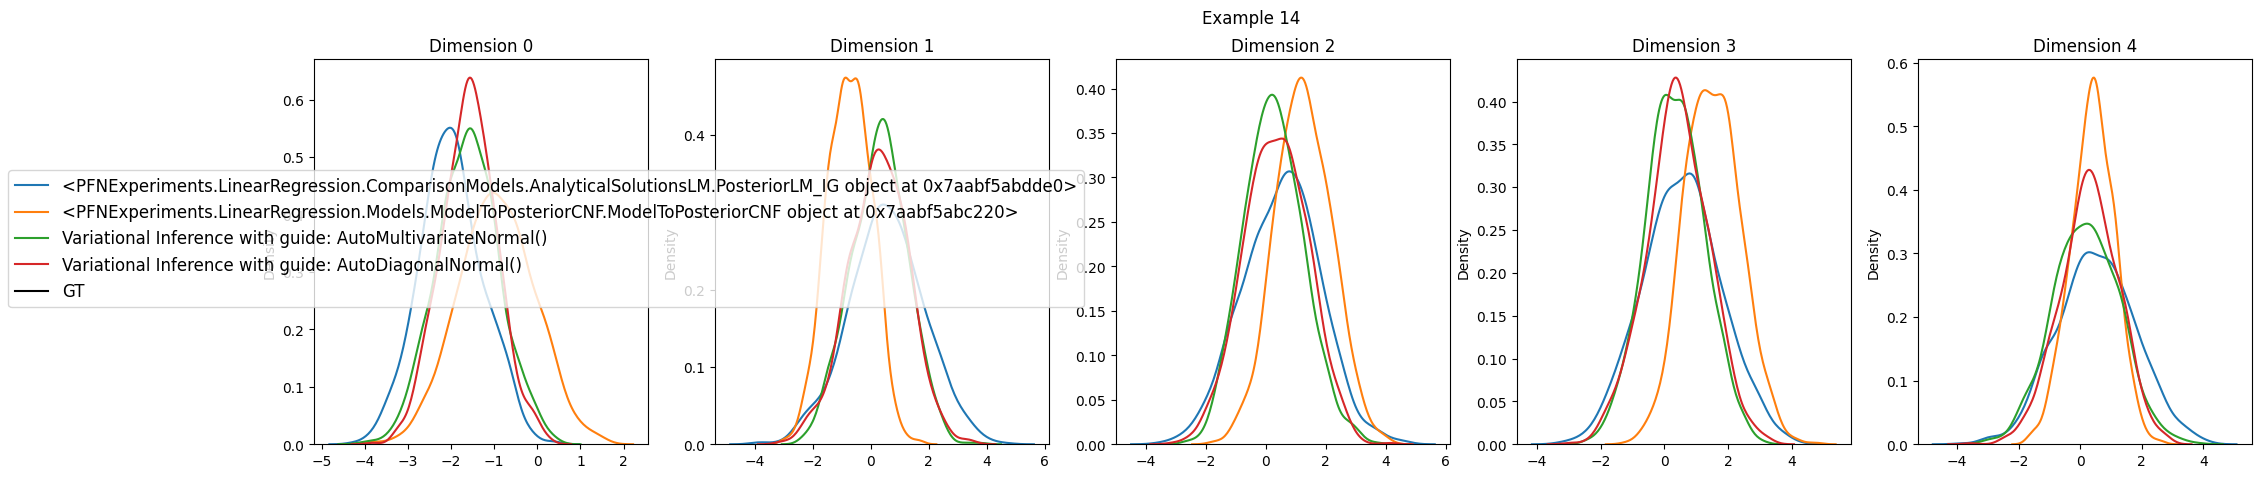

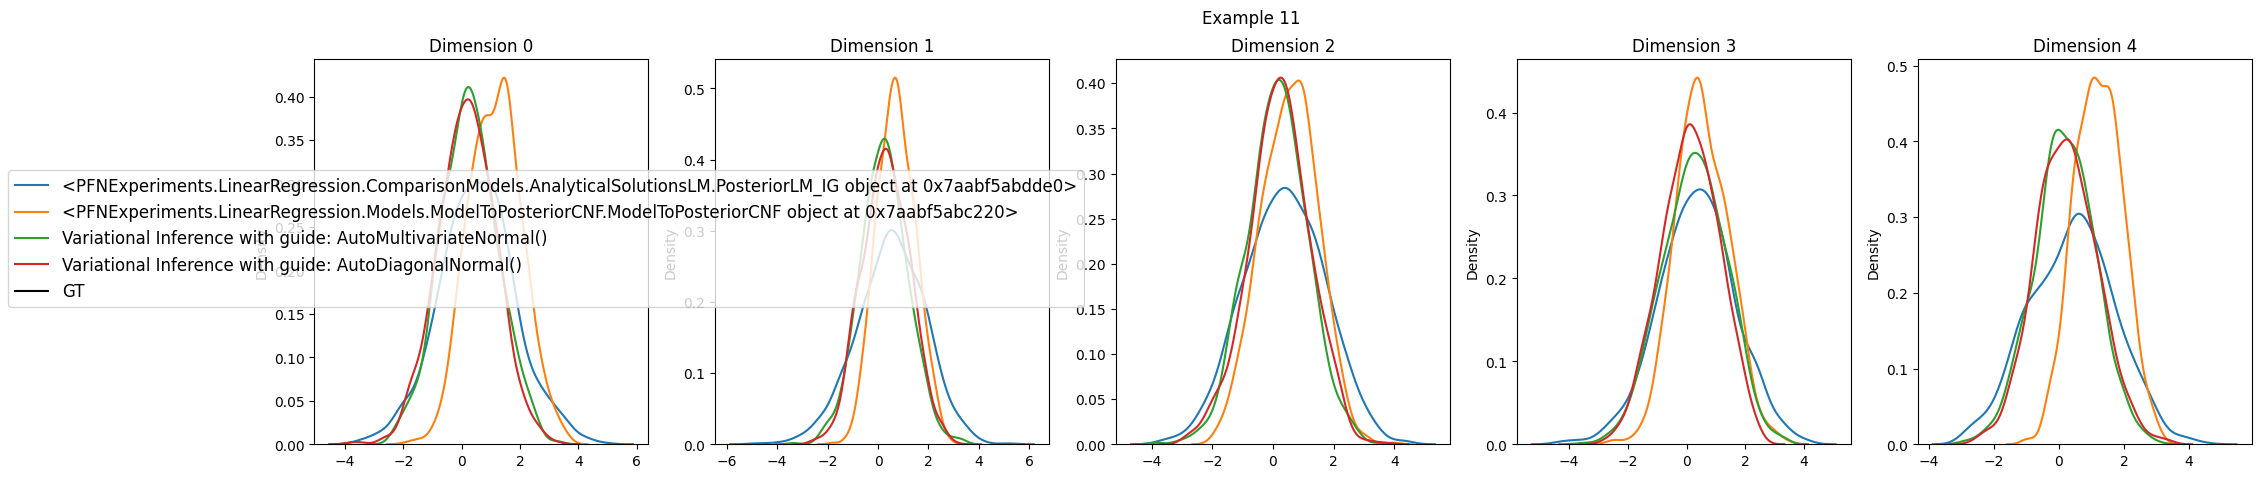

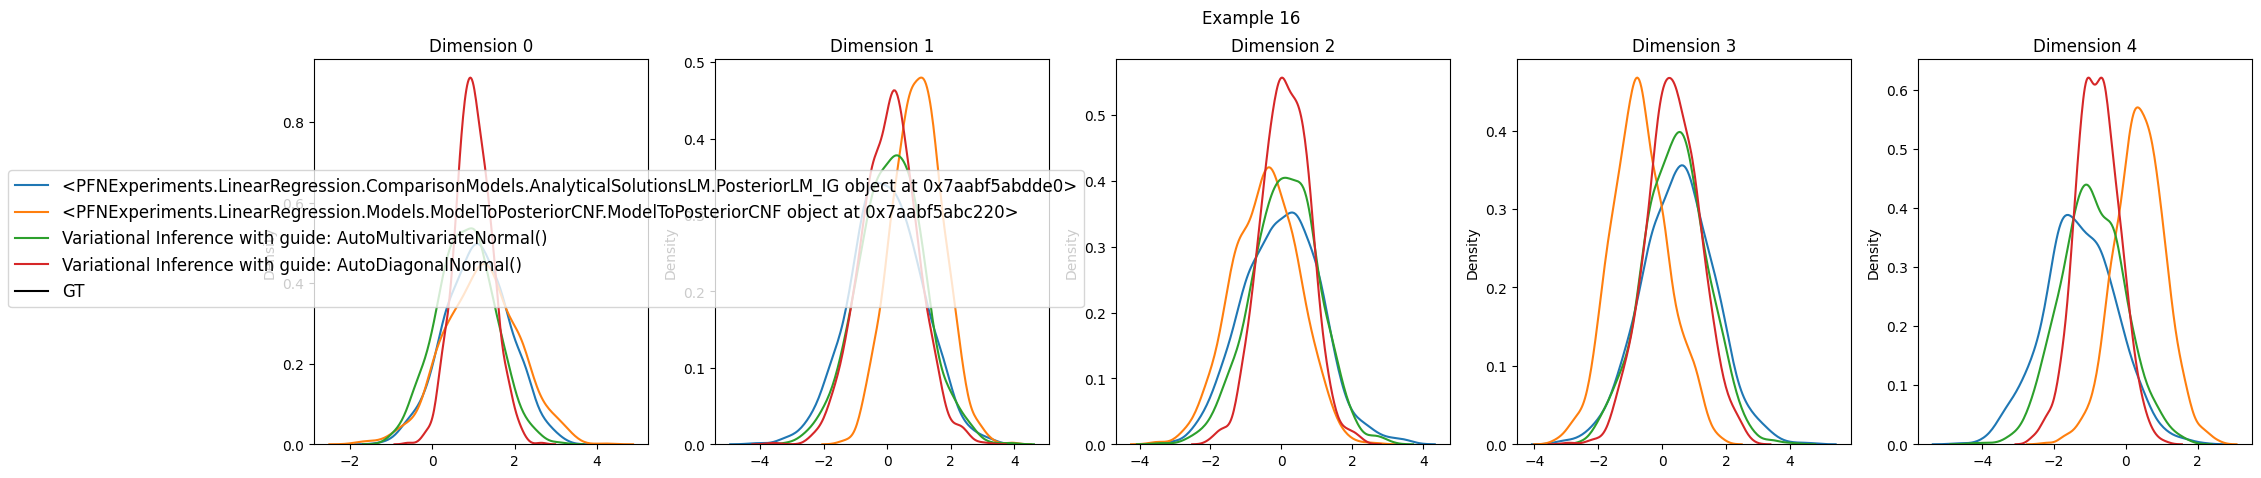

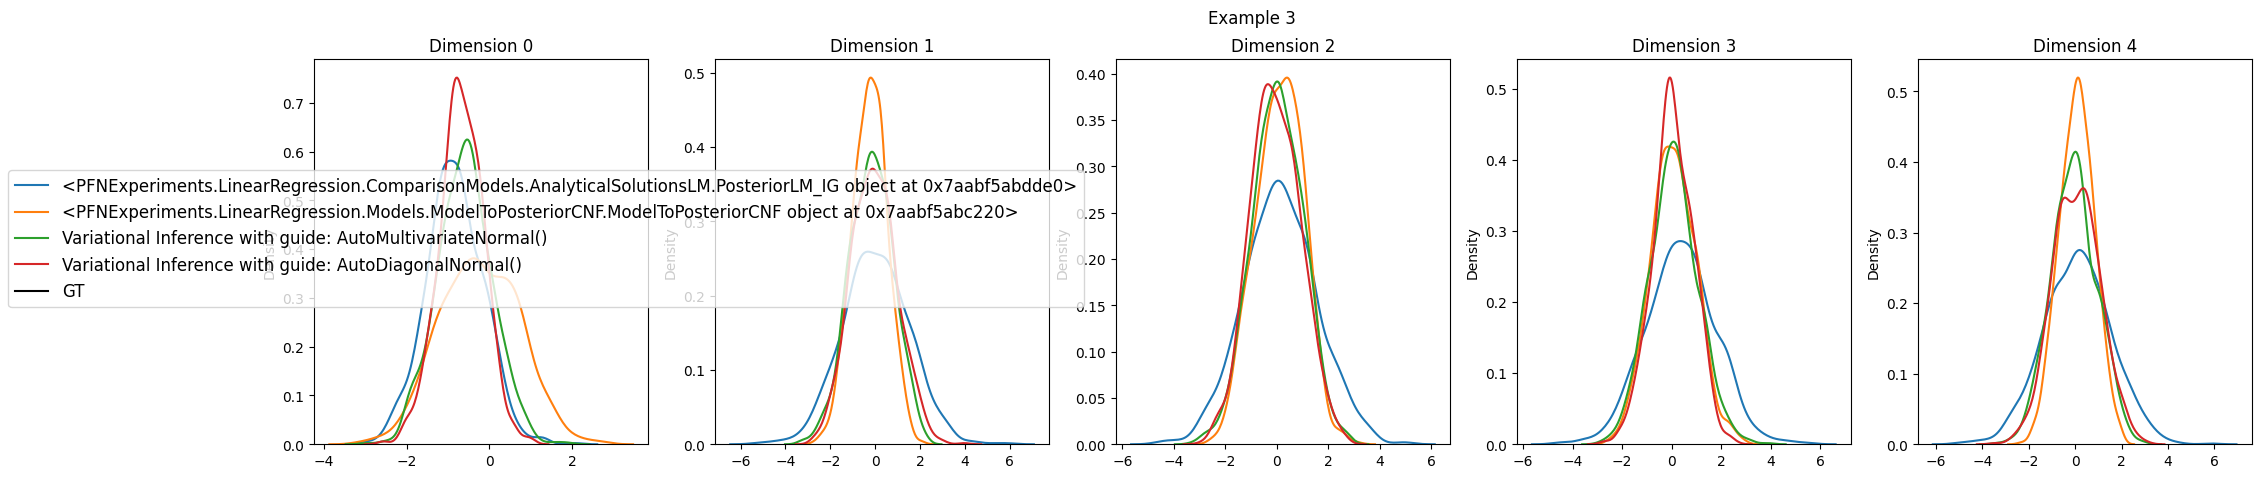

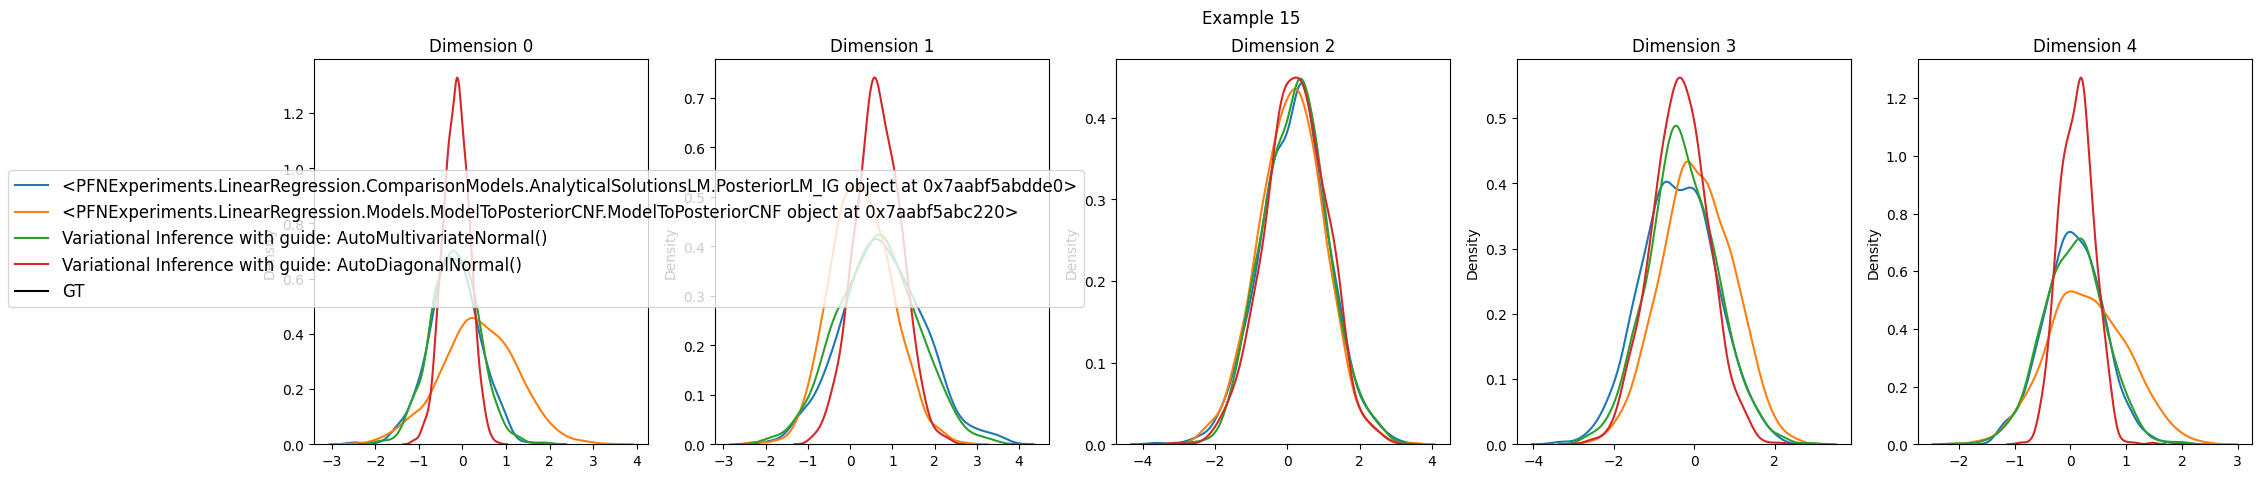

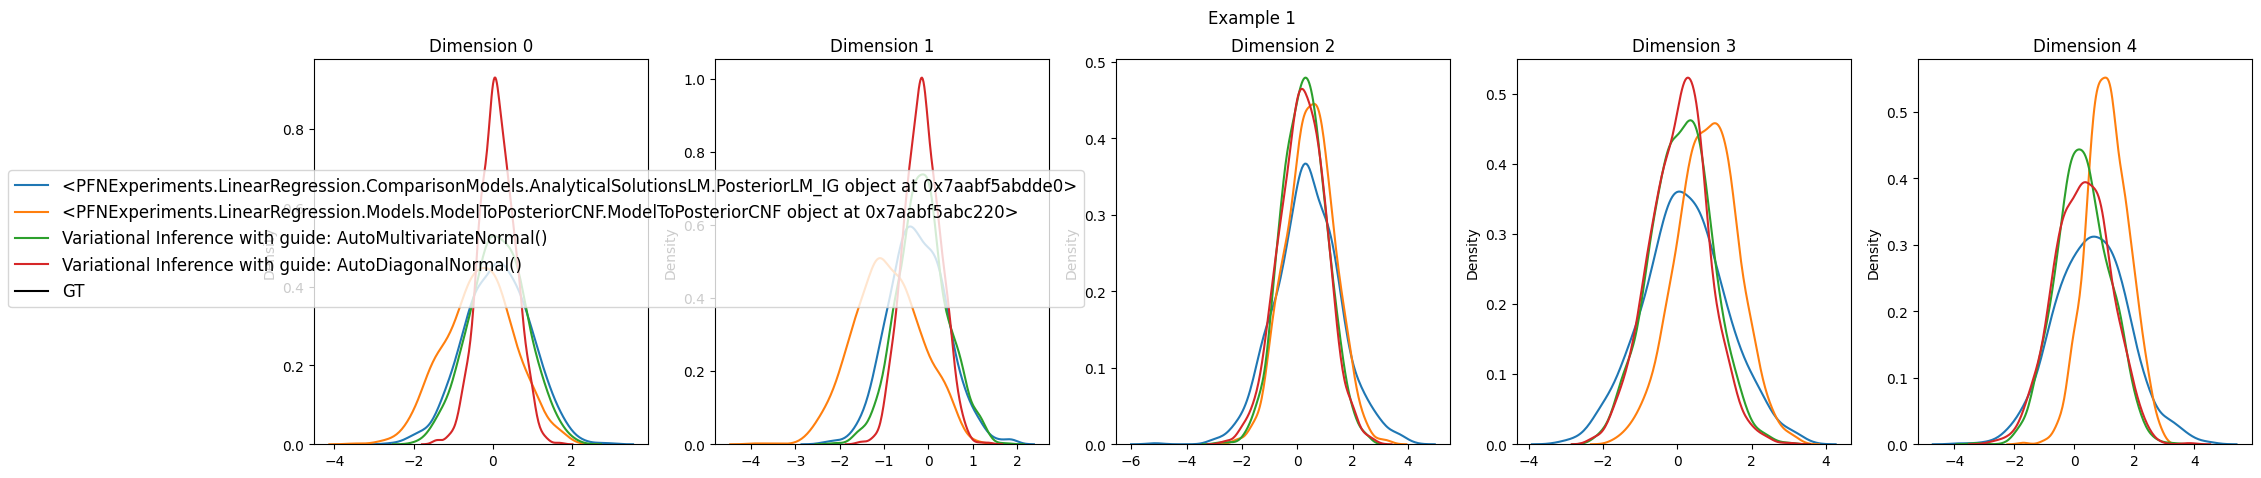

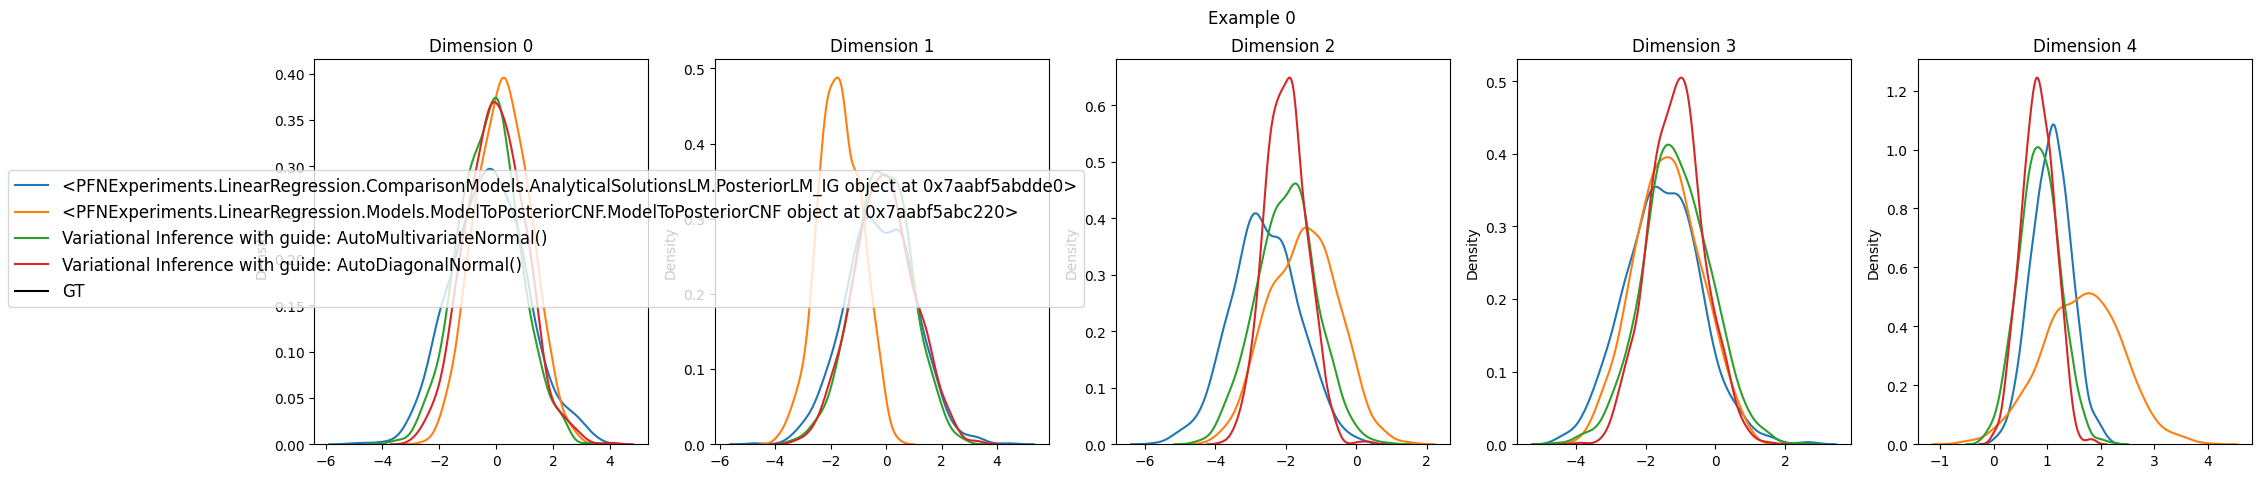

In [49]:
eval_rw.plot_results(max_number_plots=20)